In [1]:
from __future__ import print_function
import os
import cv2
import h5py
import numpy as np
from copy import deepcopy
from skimage.transform import resize
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Functions

In [3]:
def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

def get_bbox(index, hdf5_data):
    all_iterm_data = []
    item = hdf5_data['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = hdf5_data[item][key]
        values = [hdf5_data[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        # Matlab to python --indexing correction
        if key == 'left'or key == 'top':
            values_idx_corr = [val-1 for val in values]
            all_iterm_data.append(values_idx_corr)
        else:
            all_iterm_data.append(values)

    return all_iterm_data

def biggest_box(all_data, sample_index, total_samples):
    all_left  = []
    all_top   = []
    all_width = []
    all_heigt = []

    for k in range(total_samples):
        sample_left  = abs(int(all_data[sample_index][1][1][k]))
        sample_top   = abs(int(all_data[sample_index][1][2][k]))
        sample_width = abs(int(all_data[sample_index][1][3][k]))
        sample_heigt = abs(int(all_data[sample_index][1][4][k]))

        all_left.append(sample_left)
        all_top.append(sample_top)
        all_width.append(sample_left+sample_width)
        all_heigt.append(sample_top+sample_heigt)

    low_left = min(all_left)
    low_top  = min(all_top)
    highest_width = max(all_width) - low_left
    highest_height = max(all_heigt) - low_top

    return low_left, low_top, highest_width, highest_height

In [4]:
def load_file(curated_textfile):
    all_data = []

    with open(curated_textfile, 'r') as f:
        frames = f.readlines()

    for frame in frames:
        frame = frame.split(', ')
        iterm_data = []

        # Remove all non-interger characters
        for i in frame:
            i = i.replace("[", "")
            i = i.replace("[[", "")
            i = i.replace("]", "")
            i = i.replace("]]", "")
            i = i.replace("'", "")

            iterm_data.append(int(i))

        final_data = []

        count = 0
        for u in range(max_steps):
            each_data = []
            for k in range(6):
                if k == 0:
                    each_data.append(str(iterm_data[count]) + '.png')
                else:
                    each_data.append(iterm_data[count])

                count += 1

            final_data.append(each_data)

        all_data.append(final_data)

    return all_data

### Main

In [5]:
#----------------------------Arguments---------------------------------------
dataset_type     = 'test' # Change to train/test
dataset_dir      = './dataset'
curated_dataset  = os.path.join(dataset_dir, dataset_type + '_cropped')
curated_textfile = os.path.join(dataset_dir, dataset_type + '.txt')
file_path        = './dataset/%s/' % (dataset_type)
mat_file         = './dataset/%s/digitStruct.mat' % (dataset_type)
expand_percent   = 30
img_size         = (64, 64) # (width, height)
max_steps        = 6

if os.path.exists(curated_dataset) == False:
    os.mkdir(curated_dataset)

OSError: [Errno 2] No such file or directory: './dataset/test_cropped'

In [6]:
ground_attention_downsample = (14, 14)

In [7]:
expand_percent = expand_percent/100.0
print(expand_percent)

0.3


In [8]:
f = h5py.File(mat_file,'r')
print('Total bboxes: ', f['/digitStruct/name'].shape[0])

all_data = []
for j in range(f['/digitStruct/bbox'].shape[0]):
#for j in range(1000):
    img_name = get_name(j, f)
    row_dict = get_bbox(j, f)

    all_data.append([img_name, row_dict])

    if j%500 == 0:
        print('Completion..{%d/%d}' % (j, f['/digitStruct/bbox'].shape[0]))

print('Completion..{%d/%d}' % (f['/digitStruct/bbox'].shape[0], f['/digitStruct/bbox'].shape[0]))
print('Completed!')

Total bboxes:  13068
Completion..{0/13068}
Completion..{500/13068}
Completion..{1000/13068}
Completion..{1500/13068}
Completion..{2000/13068}
Completion..{2500/13068}
Completion..{3000/13068}
Completion..{3500/13068}
Completion..{4000/13068}
Completion..{4500/13068}
Completion..{5000/13068}
Completion..{5500/13068}
Completion..{6000/13068}
Completion..{6500/13068}
Completion..{7000/13068}
Completion..{7500/13068}
Completion..{8000/13068}
Completion..{8500/13068}
Completion..{9000/13068}
Completion..{9500/13068}
Completion..{10000/13068}
Completion..{10500/13068}
Completion..{11000/13068}
Completion..{11500/13068}
Completion..{12000/13068}
Completion..{12500/13068}
Completion..{13000/13068}
Completion..{13068/13068}
Completed!


In [9]:
# Create copy of samples to curate labels
all_data_copy = deepcopy(all_data)

### Visualize

In [10]:
sample_index = 3191

In [11]:
sample_imgph = all_data[sample_index][0]
sample_image = cv2.imread(file_path+sample_imgph)
sample_image_copy = deepcopy(sample_image)
sample_heigt_org, sample_width_org, _ = sample_image.shape
# Get how many digits:
total_samples = np.array(all_data[sample_index][1]).shape[1]
print('Path:', file_path+sample_imgph)

Path: ./dataset/test/3192.png


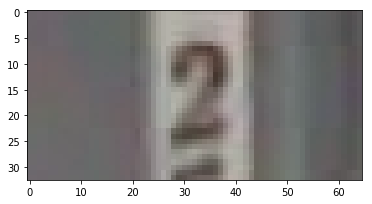

In [12]:
plt.imshow(sample_image)
plt.show()

In [13]:
all_data[sample_index]

['3192.png',
 [[2.0, 5.0], [23.0, 25.0], [1.0, 25.0], [16.0, 14.0], [15.0, 15.0]]]

In [14]:
#-------------------------------------------------------------------
## Get bounding box encompassing all digits
low_left, low_top, high_width, high_height = biggest_box(all_data=all_data,\
                      sample_index=sample_index, total_samples=total_samples)

(-0.5, 64.5, 32.5, -0.5)

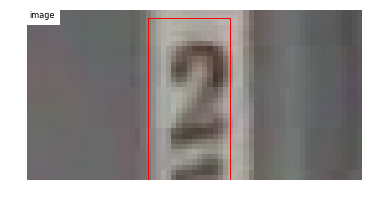

In [15]:
fig,ax = plt.subplots(1, 1)
ax.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax.imshow(sample_image)
rect = patches.Rectangle((low_left, low_top), high_width, high_height,\
                         linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.axis('off')

In [18]:
def new_x(low_x, delta_W, width, image_width):
    # Lower bound
    if delta_W//2 >= low_x:
        new_left = 0 # Reset to zero
        change1w = low_x
    elif (low_x - delta_W//2) > 0: 
        new_left = low_x - delta_W//2
        change1w = delta_W//2
    # Upper Bound
    if (low_x + width + delta_W//2) < image_width:
        change2w = delta_W//2
    else:
        change2w = image_width - (low_x + width) - 1 # Set to max-width
    # New width
    new_width = width + change1w + change2w
        
    return new_left, new_width

In [19]:
def new_y(low_y, delta_H, height, image_height):
    # Lower bound
    if (delta_H//2) >= low_y:
        new_top  = 0 # Reset to zero
        change1h = low_y
    elif (low_y - delta_H//2) > 0: 
        new_top  = low_y - delta_H//2
        change1h = delta_H//2
    # Upper Bound
    if (low_y + height + delta_H//2) < image_height:
        change2h = delta_H//2
    else:
        change2h = image_height - (low_y + height) - 1 # Set to max-height
    
    # New height
    new_height = height + change2h + change1h

    return new_top, new_height 

In [20]:
high_width_expand  = np.floor(expand_percent * high_width)
high_height_expand = np.floor(expand_percent * high_height)

In [21]:
print(high_width_expand)
print(high_height_expand)

4.0
11.0


In [22]:
lx, nW = new_x(low_x=low_left, delta_W=high_width_expand,\
               width=high_width, image_width=sample_width_org)

In [23]:
print(lx, nW)

21.0 20.0


In [24]:
ly, nH = new_y(low_y=low_top, delta_H=high_height_expand,\
               height=high_height, image_height=sample_heigt_org)

In [25]:
print(ly, nH)

0 32


(-0.5, 64.5, 32.5, -0.5)

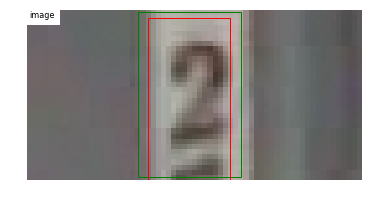

In [26]:
fig,ax = plt.subplots(1, 1)
ax.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax.imshow(sample_image)
rect = patches.Rectangle((lx, ly), nW, nH,\
                         linewidth=1, edgecolor='g', facecolor='none')
rect1 = patches.Rectangle((low_left, low_top), high_width, high_height,\
                         linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect1)
ax.axis('off')

In [27]:
print(low_left, low_top, high_width, high_height)

23 1 16 39


In [28]:
print(lx, ly, nW, nH)

21.0 0 20.0 32


In [29]:
#------- X-axis shift -------
# Update
for i in range(total_samples):
    # Update lower bound-- left
    all_data_copy[sample_index][1][1][i] -= lx       
#------- Y-axis shift-------
# Include fixed pixels from all upper bound-- top
for i in range(total_samples):
    all_data_copy[sample_index][1][2][i] -= ly

In [30]:
sample_image_copy = sample_image_copy[int(ly):int(ly + nH), int(lx):int(lx + nW), :]

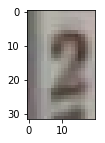

In [31]:
plt.figure(figsize=(2, 2))
plt.imshow(sample_image_copy)
plt.show()

In [32]:
#-------------------------------------------------------------------
## Get bounding box encompassing all digits
low_left, low_top, high_width, high_height = biggest_box(all_data=all_data_copy,\
                      sample_index=sample_index, total_samples=total_samples)

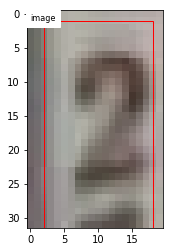

In [33]:
fig,ax = plt.subplots(1, 1)
ax.text(0, 1, 'image', color='black', backgroundcolor='white', fontsize=8)
ax.imshow(sample_image_copy)
rect = patches.Rectangle((low_left, low_top), high_width, high_height,\
                         linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

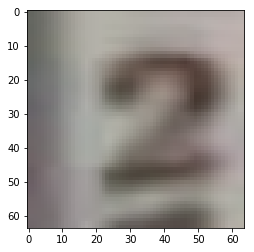

In [34]:
## Resize image
sample_heigt_org_rz, sample_width_org_rz, _ = sample_image_copy.shape

if sample_width_org_rz > img_size[0]:
    # Shrinking
    smpl_img_rz = cv2.resize(sample_image_copy, img_size, interpolation = cv2.INTER_AREA)
else:
    # Zooming
    smpl_img_rz = cv2.resize(sample_image_copy, img_size, interpolation = cv2.INTER_LINEAR)

plt.imshow(smpl_img_rz)

### Curate labels to match new image shape

In [37]:
# Collect samples
samples = []

for index_into in range(max_steps):
    if index_into == 0:
        sample_label = 0
        sample_left  = 1
        sample_top   = 1
        sample_width = 1
        sample_heigt = 1
    elif index_into > total_samples:
        sample_label = 11
        sample_left  = 0
        sample_top   = 0
        sample_width = 0
        sample_heigt = 0
    else:
        sample_label = int(all_data_copy[sample_index][1][0][index_into-1])
        sample_left  = abs(int((all_data_copy[sample_index][1][1][index_into-1] * img_size[0])/sample_width_org_rz))
        sample_top   = abs(int((all_data_copy[sample_index][1][2][index_into-1] * img_size[1])/sample_heigt_org_rz))
        sample_width = abs(int((all_data_copy[sample_index][1][3][index_into-1] * img_size[0])/sample_width_org_rz))
        sample_heigt = abs(int((all_data_copy[sample_index][1][4][index_into-1] * img_size[1])/sample_heigt_org_rz))

    # Append
    samples.append([all_data_copy[sample_index][0][:-4], sample_label, sample_left, sample_top, sample_width, sample_heigt])

In [38]:
samples

[['3192', 0, 1, 1, 1, 1],
 ['3192', 2, 6, 2, 51, 30],
 ['3192', 5, 12, 50, 44, 30],
 ['3192', 11, 0, 0, 0, 0],
 ['3192', 11, 0, 0, 0, 0],
 ['3192', 11, 0, 0, 0, 0]]

1 1 1 1
6 2 51 30
12 50 44 30
0 0 0 0
0 0 0 0
0 0 0 0


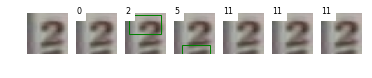

In [39]:
fig,ax = plt.subplots(1, max_steps+1)
ax[0].imshow(smpl_img_rz)
ax[0].axis('off')
        
for k in range(max_steps):
    sample_label = samples[k][1]
    sample_left  = samples[k][2]
    sample_top   = samples[k][3]
    sample_width = samples[k][4]
    sample_heigt = samples[k][5]
    
    rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
                             linewidth=1, edgecolor='g', facecolor='none')  
    print(sample_left, sample_top, sample_width, sample_heigt)    
    ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
    ax[k+1].imshow(smpl_img_rz)
    ax[k+1].add_patch(rect)
    ax[k+1].axis('off')

In [42]:
print(sample_left, sample_top, sample_width, sample_heigt)

0 0 0 0


### Extra: check attention on the resized

In [43]:
def gaussian2d(sup, scales):
    """
    Creates a 2D Gaussian based on the size and scale.
    """
    var   = scales * scales
    shape = (sup[0], sup[1])
    n,m   = [(i-1)/2 for i in shape]
    y,x   = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var))

    return g

In [44]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e_x = np.exp(x - np.max(x))

    return e_x / e_x.sum(axis=0)

In [45]:
def generate_ground_gaussian_attention_mask(sample, sample_top, sample_height, sample_left, sample_width):
    """
    Creates a ground truth attention mask based on ground truth bounding boxes,
    and scales to fit into the box.
    """
    sample_image_height, sample_image_width, _ = sample.shape 
    scales = np.sqrt(2) * 10 # Play with the standard deviation
    
    # Convert even to odd by adding extra px
    if sample_width%2 == 0:
        sample_width += 1
    
    if sample_height%2 == 0:
        sample_height += 1
    
    gaussain = gaussian2d((sample_width, sample_height), scales)
    gaussain_normalized = (gaussain - np.min(gaussain))/\
                          (np.max(gaussain) - np.min(gaussain))

    sample_attention = np.zeros((sample_image_height, sample_image_width)) * 0.0
    
    sample_attention[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width] = gaussain_normalized

    sample_attention_res  = resize(sample_attention, output_shape=ground_attention_downsample,\
                                   order=0, mode='constant',cval=0, clip=True,\
                                   preserve_range=False, anti_aliasing=False,\
                                   anti_aliasing_sigma=None)

    sample_attention_res  = sample_attention_res.flatten()

    sample_attention_res_norm = softmax(sample_attention_res)
    sample_attention_res_norm = np.reshape(sample_attention_res_norm, ground_attention_downsample)

    return sample_attention, sample_attention_res_norm

In [46]:
def generate_start_attention_mask_v1():
    """
    Create an attention mask for the stop state, which is a
    uniform mask around the digits.
    """
    sample_image_height, sample_image_width = img_size

    x = np.ones((sample_image_height, sample_image_width)) * 1.0
    x = x / (sample_image_height*sample_image_width)

    # Downsample and re-normalize between 0 and 1
    x1 = np.zeros(ground_attention_downsample) * 0.0
    x1[0, 0] = 1.0

    return x, x1

In [47]:
def generate_stop_attention_mask_v2():
    """
    Create an attention mask for the stop state, which is a
    uniform mask around the digits.
    """
    sample_image_height, sample_image_width = img_size

    x = np.zeros((sample_image_height, sample_image_width)) * 0.0
    x[-1, -1] = 1.0

    # Downsample and re-normalize between 0 and 1
    x1 = np.zeros(ground_attention_downsample) * 0.0
    x1[-1, -1] = 1.0

    return x, x1

In [48]:
def biggest_box1(samples):
    all_left  = []
    all_top   = []
    all_width = []
    all_heigt = []

    for k in range(total_samples):
        sample_label = samples[k][1]
        sample_left  = samples[k][2]
        sample_top   = samples[k][3]
        sample_width = samples[k][4]
        sample_heigt = samples[k][5]

        all_left.append(sample_left)
        all_top.append(sample_top)
        all_width.append(sample_left+sample_width)
        all_heigt.append(sample_top+sample_heigt)

    low_left = min(all_left)
    low_top  = min(all_top)
    highest_width = max(all_width) - low_left
    highest_height = max(all_heigt) - low_top
    
    return low_left, low_top, highest_width, highest_height

In [49]:
# fig,ax = plt.subplots(1, max_steps+1)
# ax[0].imshow(smpl_img_rz)
# ax[0].axis('off')
# collect_acc = []
# for k in range(max_steps):
#     sample_label = samples[k][1]
#     sample_left  = samples[k][2]
#     sample_top   = samples[k][3]
#     sample_width = samples[k][4]
#     sample_heigt = samples[k][5]

#     # Generate attention mask
#     if k == 0:
#         # Start state
#         _, attn_mask = generate_start_attention_mask_v1()
#     elif int(sample_label) == 11:
#         # End state
#         _, attn_mask = generate_stop_attention_mask_v2()
#     else:
#         attn_mask, acc = generate_ground_gaussian_attention_mask(smpl_img_rz,\
#                               sample_top, sample_heigt, sample_left, sample_width)
#         collect_acc.append(acc)
        
#     rect = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,\
#                               linewidth=1, edgecolor='r', facecolor='none')  
#     ax[k+1].text(0, 1, sample_label, color='black', backgroundcolor='white', fontsize=8)
#     ax[k+1].imshow(smpl_img_rz)
#     ax[k+1].imshow(attn_mask, alpha=0.5)
#     ax[k+1].add_patch(rect)
#     ax[k+1].axis('off')

In [50]:
# Collect samples
attn_samples = []

for k in range(max_steps):
    sample_label = samples[k][1]
    sample_left  = samples[k][2]
    sample_top   = samples[k][3]
    sample_width = samples[k][4]
    sample_heigt = samples[k][5]
    
    if k == 0:
        continue
    elif k > total_samples:
        continue
    else:
        sample_left  = int(np.floor((sample_left  * 14)/64))
        sample_top   = int(np.floor((sample_top   * 14)/64))
        sample_width = int(np.floor((sample_width * 14)/64))
        sample_heigt = int(np.floor((sample_heigt * 14)/64))

    # Append
    attn_samples.append([sample_left, sample_top, sample_width, sample_heigt])

In [51]:
print(sample_left, sample_top, sample_width, sample_heigt)

0 0 0 0


In [52]:
len(attn_samples)

2

In [72]:
def generate_ground_gaussian_attention_mask_v2(sample_size, sample_top, sample_height, sample_left, sample_width):
    """
    Creates a ground truth attention mask based on ground truth bounding boxes,
    and scales to fit into the box.
    """
    sample_image_height, sample_image_width = sample_size
    print(sample_top, sample_height, sample_left, sample_width)
    scales = np.sqrt(2) * 5 # Play with the standard deviation
    
    # Check size:
    if sample_left + sample_width >= sample_image_width:
        delta_w = (sample_left + sample_width) - sample_image_width
        sample_width -= delta_w

    if sample_top + sample_height >= sample_image_height:
        delta_h = (sample_top + sample_height) - sample_image_height
        sample_height -= delta_h

    print(sample_height, sample_width)
    # Convert even to odd by adding or removing extra px
    if sample_width%2 == 0:
        if sample_left + sample_width + 1 >= sample_image_width:
            sample_width -= 1
        else:
            sample_width += 1
    
    if sample_height%2 == 0:
        if sample_top + sample_height + 1 >= sample_image_height:
            sample_height -= 1
        else:
            sample_height += 1
            
    print(sample_height, sample_width)
    gaussain = gaussian2d((sample_width, sample_height), scales)
    print(gaussain.shape)
    gaussain_normalized = (gaussain - np.min(gaussain))/\
                          (np.max(gaussain) - np.min(gaussain))
    h_gauss_norm, w_gauss_norm = gaussain_normalized.shape
    gaussain_normalized = gaussain_normalized.flatten()
    gaussain_normalized = softmax(gaussain_normalized)
    gaussain_normalized = np.reshape(gaussain_normalized, (h_gauss_norm, w_gauss_norm))
    
    sample_attention = np.zeros((sample_image_height, sample_image_width)) * 0.0
    print(sample_top, sample_top+sample_height)
    print(sample_left,sample_left+sample_width)
    
    sample_attention[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width] = gaussain_normalized

    return sample_attention

In [73]:
# Collect samples
gen_samples = []
for k in range(len(attn_samples)):
    sample_left  = attn_samples[k][0]
    sample_top   = attn_samples[k][1]
    sample_width = attn_samples[k][2]
    sample_heigt = attn_samples[k][3]
    
    gen_sample = generate_ground_gaussian_attention_mask_v2((14,14), sample_top, sample_heigt, sample_left, sample_width)
    print('---------------------------')
    gen_samples.append(gen_sample)

0 6 1 11
6 11
7 11
(7, 11)
0 7
1 12
---------------------------
10 6 2 9
4 9
3 9
(3, 9)
10 13
2 11
---------------------------


In [74]:
attn_samples

[[1, 0, 11, 6], [2, 10, 9, 6]]

In [75]:
gen_samples[0].shape

(14, 14)

In [76]:
gen_samples[0]

array([[0.        , 0.00714115, 0.00901088, 0.01096108, 0.01271689,
        0.01395324, 0.01440049, 0.01395324, 0.01271689, 0.01096108,
        0.00901088, 0.00714115, 0.        , 0.        ],
       [0.        , 0.00810504, 0.01034981, 0.01271689, 0.01486678,
        0.01638992, 0.01694266, 0.01638992, 0.01486678, 0.01271689,
        0.01034981, 0.00810504, 0.        , 0.        ],
       [0.        , 0.00877185, 0.01128502, 0.01395324, 0.01638992,
        0.01812286, 0.01875297, 0.01812286, 0.01638992, 0.01395324,
        0.01128502, 0.00877185, 0.        , 0.        ],
       [0.        , 0.00901088, 0.01162192, 0.01440049, 0.01694266,
        0.01875297, 0.01941166, 0.01875297, 0.01694266, 0.01440049,
        0.01162192, 0.00901088, 0.        , 0.        ],
       [0.        , 0.00877185, 0.01128502, 0.01395324, 0.01638992,
        0.01812286, 0.01875297, 0.01812286, 0.01638992, 0.01395324,
        0.01128502, 0.00877185, 0.        , 0.        ],
       [0.        , 0.00810504, 0.0

In [77]:
np.sum(gen_samples[0])

1.0

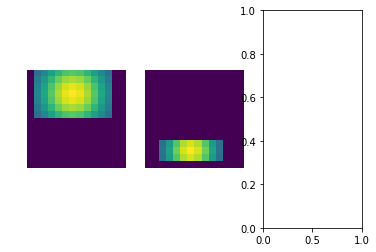

In [78]:
fig,ax = plt.subplots(1, len(gen_samples)+1)
for k in range(len(gen_samples)):
    ax[k].imshow(gen_samples[k])
    ax[k].axis('off')

In [50]:
for k in range(len(gen_samples)):
    print(np.min(gen_samples[k]))
    print(np.max(gen_samples[k]))
    print('--------------------')

0.0
0.012485610428483994
--------------------
